# BetterWrapped

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pycountry
import seaborn as sns

## Importing Spotify data

### Reading data

In [2]:
df = pd.DataFrame()
for file in [x for x in os.listdir("Spotify Extended Streaming History") if x.startswith("Streaming_History_Audio")]:
    df = pd.concat([df, pd.read_json("Spotify Extended Streaming History/"+file)])
df.head(3)

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2018-11-12T19:09:12Z,"Android OS 8.0.0 API 26 (LGE, LG-H870)",0,CH,84.74.88.79,Let You Love Me,Rita Ora,Let You Love Me,spotify:track:6xtcFXSo8H9BZN637BMVKS,None,...,NaN,NaN,NaN,clickrow,remote,False,False,False,NaN,False
1,2018-11-12T19:09:31Z,Partner sonos_ppc Sonos;Play5;;;,12500,CH,84.74.88.79,Let You Love Me,Rita Ora,Let You Love Me,spotify:track:6xtcFXSo8H9BZN637BMVKS,None,...,NaN,NaN,NaN,clickrow,endplay,False,False,False,NaN,False
2,2018-11-12T19:11:02Z,Partner sonos_ppc Sonos;Play5;;;,38500,CH,84.74.88.79,Happier,Marshmello,Happier,spotify:track:2dpaYNEQHiRxtZbfNsse99,None,...,NaN,NaN,NaN,clickrow,logout,False,False,False,NaN,False


### Formatting and cleaning data

In [3]:
df = df.drop(columns=["episode_name", "episode_show_name", "spotify_episode_uri", "audiobook_title", "audiobook_uri", "audiobook_chapter_uri", "audiobook_chapter_title"])
df.rename(columns={"conn_country":"country_code", "ip_addr":"ip", "master_metadata_track_name":"track_name", "master_metadata_album_artist_name":"artist_name", "master_metadata_album_album_name":"album_name"}, inplace=True)
df["ts"] = pd.to_datetime(df["ts"])
df = df.dropna(subset=["artist_name"])
df["s_played"] = df["ms_played"]/1000
df["min_played"] = df["s_played"]/60
df["h_played"] = df["min_played"]/60
df["d_played"] = df["min_played"]/24
df["country_name"] = df["country_code"].map(lambda x : pycountry.countries.get(alpha_2=x).name if pycountry.countries.get(alpha_2=x) else "Unbekannt")
df.head(3)

,ts,platform,ms_played,country_code,ip,track_name,artist_name,album_name,spotify_track_uri,reason_start,...,shuffle,skipped,offline,offline_timestamp,incognito_mode,s_played,min_played,h_played,d_played,country_name
0,2018-11-12 19:09:12+00:00,"Android OS 8.0.0 API 26 (LGE, LG-H870)",0,CH,84.74.88.79,Let You Love Me,Rita Ora,Let You Love Me,spotify:track:6xtcFXSo8H9BZN637BMVKS,clickrow,...,False,False,False,NaN,False,0.0,0.000000,0.000000,0.000000,Switzerland
1,2018-11-12 19:09:31+00:00,Partner sonos_ppc Sonos;Play5;;;,12500,CH,84.74.88.79,Let You Love Me,Rita Ora,Let You Love Me,spotify:track:6xtcFXSo8H9BZN637BMVKS,clickrow,...,False,False,False,NaN,False,12.5,0.208333,0.003472,0.008681,Switzerland
2,2018-11-12 19:11:02+00:00,Partner sonos_ppc Sonos;Play5;;;,38500,CH,84.74.88.79,Happier,Marshmello,Happier,spotify:track:2dpaYNEQHiRxtZbfNsse99,clickrow,...,False,False,False,NaN,False,38.5,0.641667,0.010694,0.026736,Switzerland


## Fetching genres

https://developer.spotify.com/

In [4]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException
import requests

In [5]:
CLIENT_ID = "0c5021071fbd4a9fabc9b31b278aaae7"
CLIENT_SECRET = "d2cce0d0a87d433e96f0a8d4d5bf3b51"

In [6]:
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [7]:
def fetch_artist_genre(sp, artist, max_retries=5, initial_wait=5):
    tries = 0
    wait = initial_wait
    while tries < max_retries:
        try:
            genre = sp.search(q=artist, type="artist")["artists"]["items"][0]["genres"]
            return genre
        except (requests.exceptions.ReadTimeout, SpotifyException):
            time.sleep(wait)
            wait *= 2
            tries += 1
    return []

In [8]:
if not "artist_genre.csv" in os.listdir():
    artists = df["artist_name"].unique()
    list_artist_genre = [[artist, fetch_artist_genre(sp, artist)] for artist in artists]
    list_artist_genre = [[artist, ", ".join(genres)] for artist, genres in list_artist_genre]
    df_artist_genre = pd.DataFrame(list_artist_genre, columns=["artist_name", "genre"])
    df_artist_genre.to_csv("artist_genre.csv", index=False)
else:
    df_artist_genre = pd.read_csv("artist_genre.csv")

In [9]:
df = df.merge(df_artist_genre, on="artist_name", how="left")

## Fetching IP geolocation

https://github.com/ipinfo/python?tab=readme-ov-file#lite-api
https://ipinfo.io

In [10]:
import ipinfo

In [11]:
access_token = "44f4e46f292505"

In [12]:
handler = ipinfo.getHandler(access_token)

In [13]:
def fetch_ip_loc(handler, ip, max_retries=5, initial_wait=5, timeout=10):
    tries = 0
    wait = initial_wait
    while tries < max_retries:
        try:
            details = handler.getDetails(ip, timeout)
            return details
        except (requests.exceptions.ReadTimeout):
            time.sleep(wait)
            wait *= 2
            tries += 1
    return []

In [22]:
if not "ip_loc.csv" in os.listdir():
    list_ip_loc = [[ip, fetch_ip_loc(handler, ip).loc, fetch_ip_loc(handler, ip).city, fetch_ip_loc(handler, ip).region] for ip in df["ip"].unique()]
    df_ip_loc = pd.DataFrame(list_ip_loc, columns=["ip", "geo_loc", "city_name", "region_name"])
    df_ip_loc.to_csv("ip_loc.csv", index=False)
else:
    df_ip_loc = pd.read_csv("ip_loc.csv")
df[['lat', 'lon']] = df['geo_loc'].str.split(',', expand=True)
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

In [15]:
df = df.merge(df_ip_loc, on="ip", how="left")

## Explaining data

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85534 entries, 0 to 85533
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   ts                 85534 non-null  datetime64[ns, UTC]
 1   platform           85534 non-null  object             
 2   ms_played          85534 non-null  int64              
 3   country_code       85534 non-null  object             
 4   ip                 85534 non-null  object             
 5   track_name         85534 non-null  object             
 6   artist_name        85534 non-null  object             
 7   album_name         85534 non-null  object             
 8   spotify_track_uri  85534 non-null  object             
 9   reason_start       85534 non-null  object             
 10  reason_end         85534 non-null  object             
 11  shuffle            85534 non-null  bool               
 12  skipped            85534 non-null  bool       

| Attribute | Description |
|-----------|-------------|
| ts | This field is a timestamp indicating when the track stopped playing in UTC (Coordinated Universal Time). The order is year, month and day followed by a timestamp in military time |
| platform | This field is the platform used when streaming the track (e.g. Android OS, Google Chromecast). |
| ms_played | This field is the number of milliseconds the stream was played. |
| country_code | This field is the country code of the country where the stream was played (e.g. SE - Sweden). |
| ip | This field contains the IP address logged when streaming the track. |
| track_name | This field is the name of the track. |
| artist_name | This field is the name of the artist, band or podcast. |
| album_name | This field is the name of the album of the track. |
| spotify_track_uri  | A Spotify URI, uniquely identifying the track in the form of “spotify:track:<base-62 string>” <br><br> A Spotify URI is a resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an artist, album, or track. |
| reason_start | This field is a value telling why the track started (e.g. “trackdone”) |
| reason_end | This field is a value telling why the track ended (e.g. “endplay”). |
| shuffle | This field has the value True or False depending on if shuffle mode was used when playing the track. |
| skipped | This field indicates if the user skipped to the next song |
| offline | This field indicates whether the track was played in offline mode (“True”) or not (“False”). |
| offline_timestamp | This field is a timestamp of when offline mode was used, if used. |
| incognito_mode | This field indicates whether the track was played during a private session (“True”) or not (“False”). |
| s_played | This field is the number of seconds the stream was played.|
| min_played | This field is the number of minutes the stream was played.|
| h_played | This field is the number of hours the stream was played.|
| d_played | This field is the number of days the stream was played.|
| country_name | This field is the country name of the country where the stream was played (e.g. Sweden - SE).|
| genre | This field is the genre of the artist |
| geo_loc | This field is the location coordinates in the format (latitude,longitude) where the stream was played. |
| city_name | This field is the city name of the city where the stream was played. |
| region_name | This field is the region name of the region where the stream was played. |
| lat | This field is the latitudinal location coordinates from where the stream was played. |
| lon | This field is the longitudinal location coordinates from where the stream was played. |

## Exploring static data

### Your Spotify usage

In [17]:
print("You started using Spotify in", df["ts"].min().date())
print("You listened to ", df.shape[0], " tracks, over the course of ", (df["ts"].max() - df["ts"].min()).days, " days (", round((df["ts"].max() - df["ts"].min()).days/365, 2), " years)", sep="")
print("You listened to Spotify for ", df["ms_played"].sum()//3600000, " hours (", df["ms_played"].sum()//3600000//24, " days)", sep="")

You started using Spotify in 2018-11-12
You listened to 85534 tracks, over the course of 2542 days (6.96 years)
You listened to Spotify for 2567 hours (106 days)


### Your "favourites"

In [18]:
def get_top_data_raw(attribute, sorting_value, top_count, start = df["ts"].min(), end = df["ts"].max()):
    if sorting_value == "track_count":
        if attribute == "genre":
            return df[(df["ts"] > start) & (df["ts"] < end)][attribute].str.split(", ").explode().value_counts()[:top_count].reset_index()
        else:
            return df[(df["ts"] > start) & (df["ts"] < end)][attribute].value_counts()[:top_count].reset_index()
    elif sorting_value == "listening_time":
        if attribute == "genre":
            return df[(df["ts"] > start) & (df["ts"] < end)][[attribute, "h_played"]].assign(genre=df[attribute].str.split(", ")).explode(attribute).groupby(attribute)["h_played"].sum().sort_values(ascending=False)[:top_count].reset_index().round(1)
        else:
            return df[(df["ts"] > start) & (df["ts"] < end)][[attribute, "h_played"]].groupby(attribute).sum().sort_values("h_played", ascending=False)[:top_count].reset_index().round(1)

In [19]:
attribute = "genre" #artist_name, track_name, genre, album_name, country_name, region_name, city_name or platform
top_count = 10
sorting_value = "listening_time" #track_count or listening_time
get_top_data_raw(attribute, sorting_value, top_count, start="2025") #start="year-month-day", end="year-month-day"

,genre,h_played
0,german pop,58.2
1,german hip hop,55.6
2,german indie,53.1
3,german indie pop,40.4
4,rock,27.2
5,classic rock,22.2
6,indie,16.2
7,dream pop,11.7
8,alternative metal,11.4
9,psychedelic rock,11.3


## Exploring dynamic data

In [24]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

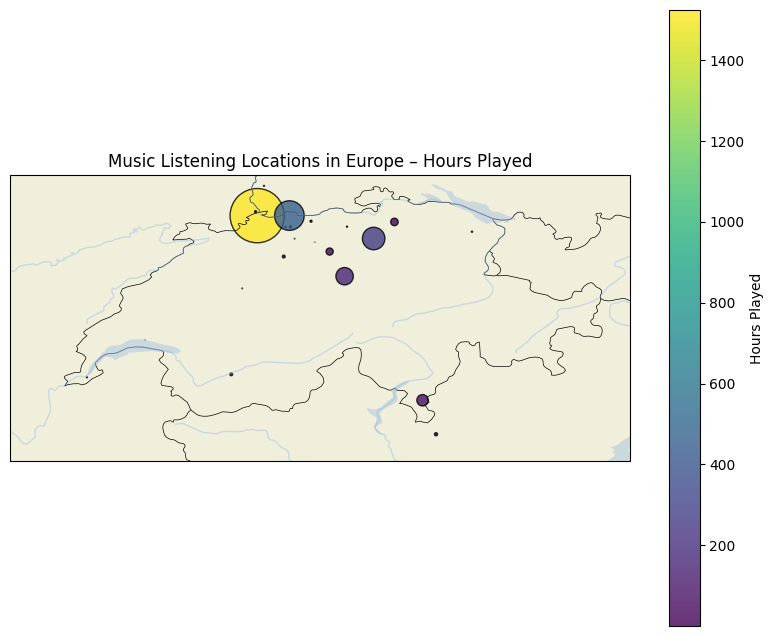

In [32]:
# Create the figure
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.add_feature(cfeature.RIVERS, alpha=0.4)

# 🔍 Set map view to Europe
ax.set_extent([5.5, 10.7, 45.5, 47.9])  # [west, east, south, north]

# Title
plt.title("Music Listening Locations in Europe – Hours Played")

# Scatter data
plt.scatter(
    agg['lon'], agg['lat'],
    s = agg['h_played'],  # scale bubbles
    c = agg['h_played'],
    cmap='viridis',
    alpha=0.8,
    edgecolor='k',
    transform=ccrs.PlateCarree()
)

# Add color scale
cbar = plt.colorbar(label="Hours Played")
cbar.set_label("Hours Played")

plt.show()